In [ ]:
#Train custom CNN model 
#Dataset original size : 256 x 256
#Resized to 224 x 224

#Trained on 20000 healthy images and approx. 6500 3+ subtypes hemorrhages images

In [1]:
#Load libraries

#Data management, analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os
import random

#Train-test split
from sklearn.model_selection import train_test_split # split data into train and test sets

#Image manipulation
from skimage.io import imread_collection
import skimage.io
import skimage.color
import skimage.transform
from PIL import Image

#Import Keras libraries and packages
import tensorflow as tf
from tensorflow import keras
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop


**Loading and Pre-processing Data**

In [ ]:
#If not using google colab, please skip to the cell 'Extract filenames..'

In [2]:
#If using google colab and accessing kaggle dataset
#To get dataset from kaggle to use in google colab, refer to this blog, https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

#from google.colab import files
#files.upload() #upload kaggle.json


In [3]:
#Setting up and installing kaggle library

#!pip install --upgrade --force-reinstall --no-deps kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Download the dataset from kaggle
#https://www.kaggle.com/jhoward/rsna-hemorrhage-jpg

#! kaggle datasets download jhoward/rsna-hemorrhage-jpg

In [5]:
#Extract the files 

#!unzip rsna-hemorrhage-jpg.zip

In [2]:
#Extract filenames from the folder of images

filenames = []
for root, dirs, files in os.walk('archive/train_jpg/train_jpg'):
    for file in files:
        if file.endswith('.jpg'):
            filenames.append(file)

In [3]:
len(filenames)

194082

In [4]:
#Load the labels file
labels = pd.read_feather('archive/meta/meta/labels.fth')



In [5]:
#Go through filename list to remove the .jpg at the end
idstosearch = [item.rstrip(".jpg") for item in filenames]

#Search the "ID" column for IDs that correspond to the filenames
labels = labels[labels['ID'].isin(idstosearch)]

In [6]:
#Obtain dataset with only images with 3+ hemorrhages types and healthy images that are randomized

random.seed(10)
images_hem = labels[labels[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1) >= 3].copy()
images_healthy = labels[labels['any'] == 0].copy()
images_healthy = images_healthy.sample(n = 20000)
frames = [images_healthy, images_hem]
images_data = pd.concat(frames)
images_data = images_data.sort_values('ID')
print("Number of images with hemorrhage: "+"{}".format(len(images_hem)))
print("Number of healthy images: "+"{}".format(len(images_healthy)))
print("Percent of dataset with 3+ hemorrhage types: "+"{:.2%}".format(len(images_hem)/len(images_data)))

Number of images with hemorrhage: 6547
Number of healthy images: 20000
Percent of dataset with 3+ hemorrhage types: 24.66%


In [7]:
#function to resize image files and add to numpy array

def convert_img(path):
    #path - path to the image file
    #returns image as numpy array
    img = image.load_img(path, target_size = (224,224))
    img = image.img_to_array(img)
    return img

In [8]:
#Import images from the dataset

imagelist = images_data['ID']
imageids = ["archive/train_jpg/train_jpg/"+ x + ".jpg" for x in imagelist]
images = imread_collection(imageids)



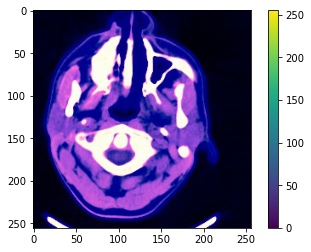

In [9]:
# Plot the first image
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
#Visualize the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

In [11]:
#Convert images into numpy arrays and resize the images

images_arr =np.array([convert_img(img)
                    for img in imageids])



print(images_arr.shape)

(26547, 224, 224, 3)

In [ ]:
#Convert images to numpy array if not want to resize

#images_arr = np.array(images)
#print(images_arr.shape)

In [12]:
labels = images_data.iloc[:, 1]

In [13]:
#Convert images to numpy array

labels = pd.Series.to_numpy(labels)



print(labels.shape)

(26547, 224, 224, 3)
(26547,)


In [14]:
#Splitting dataset into train, validation and test sets at 80%, 10% and 10% respectively.

#Split data into train and remaining dataset
train, X_re, labels_train, y_re = train_test_split(images_arr, labels, train_size=0.80,stratify=labels,random_state=1)

#Split remaining data into test and validation with 50% split 
val, test, labels_val, labels_test = train_test_split(X_re, y_re, test_size=0.5, stratify=y_re,random_state=1)

In [15]:
print(train.shape)
print(test.shape)
print(val.shape)
print(labels_train.shape)
print(labels_test.shape)
print(labels_val.shape)


(21237, 224, 224, 3)
(2655, 224, 224, 3)
(2655, 224, 224, 3)
(21237,)
(2655,)
(2655,)


In [29]:
#Convolution Neural Network (Deep-CNN)

CNN_model = Sequential()
CNN_model.add(Conv2D(32, kernel_size=(5, 5), 
                 activation='relu', input_shape=(224, 224, 3)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))
CNN_model.add(Conv2D(64, (5, 5), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='relu'))
CNN_model.add(Dense(1, activation='sigmoid'))
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 110, 110, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 53, 53, 64)       

In [17]:
#Normalize the images by dividing each pixel by 255


train_datagen = ImageDataGenerator(rescale = 1./255,
                                    )
val_datagen = ImageDataGenerator(rescale = 1./255,
                                    )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                    )

In [19]:
train_generator = train_datagen.flow(train, labels_train, batch_size=32)

validation_generator = val_datagen.flow(val, labels_val, batch_size= 32)

In [31]:


CNN_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])


In [32]:
history = CNN_model.fit(train_generator, steps_per_epoch=100,epochs = 10, validation_data = validation_generator, verbose =1)

Epoch 1/10
100/100 [==============================] - 344s 3s/step - loss: 0.8215 - acc: 0.7297 - val_loss: 0.4716 - val_acc: 0.7800
Epoch 2/10
100/100 [==============================] - 374s 4s/step - loss: 0.4004 - acc: 0.8103 - val_loss: 0.4510 - val_acc: 0.8117
Epoch 3/10
100/100 [==============================] - 346s 3s/step - loss: 0.3586 - acc: 0.8460 - val_loss: 0.5389 - val_acc: 0.7846
Epoch 4/10
100/100 [==============================] - 342s 3s/step - loss: 0.3335 - acc: 0.8584 - val_loss: 0.4010 - val_acc: 0.8648
Epoch 5/10
100/100 [==============================] - 330s 3s/step - loss: 0.2944 - acc: 0.8733 - val_loss: 0.3541 - val_acc: 0.8663
Epoch 6/10
100/100 [==============================] - 331s 3s/step - loss: 0.2712 - acc: 0.8934 - val_loss: 0.3701 - val_acc: 0.8610
Epoch 7/10
100/100 [==============================] - 335s 3s/step - loss: 0.2781 - acc: 0.8869 - val_loss: 0.3633 - val_acc: 0.8591
Epoch 8/10
100/100 [==============================] - 339s 3s/step - 

In [33]:
CNN_model.save('CNNmodel.h5')

Text(0.5, 1.0, 'Training and validation loss')

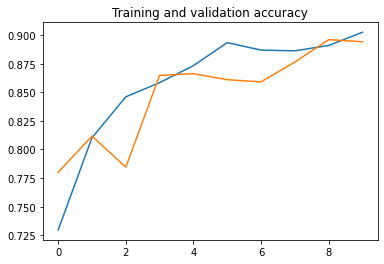

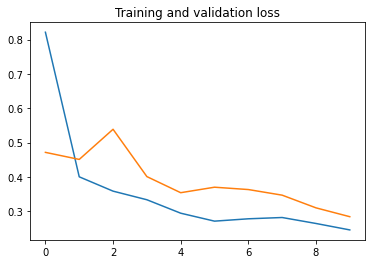

In [34]:


# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
#Evaluate metrics
 
train_acc =CNN_model.evaluate(train_generator, verbose=1)
val_acc = CNN_model.evaluate(validation_generator, verbose=1)

In [ ]:
#Test the model

test_generator = test_datagen.flow(test, labels_test, batch_size= 32)
predictions = CNN_model.predict(test_generator)

test_loss, test_acc = CNN_model.evaluate(test_generator, verbose=1)
print("Test Accuracy: "+"{:.2%}".format(test_acc))